In [1]:
library(tidyverse)
library(repr)
library(readxl)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Parsed with column specification:
cols(
  mean_int_prof = col_double(),
  sd_int_prof = col_double(),
  kurt_int_prof = col_double(),
  skew_int_prof = col_double(),
  mean_curve = col_double(),
  sd_curve = col_double(),
  kurt_curve = col_double(),
  skew_curve = col_double(),
  class = col_double()
)



Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

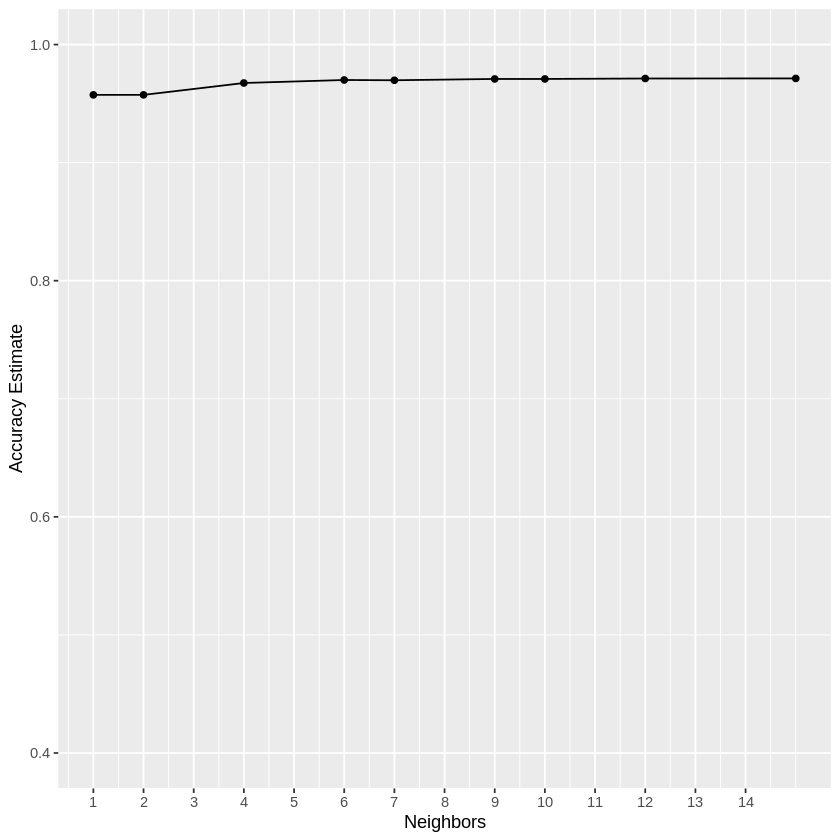

In [11]:
pulsar_data <- read_csv("https://raw.githubusercontent.com/glenren/dsci_100_group_24/main/HTRU_2.csv", 
                        col_names = c("mean_int_prof", 
                                      "sd_int_prof",
                                      "kurt_int_prof",
                                      "skew_int_prof",
                                      "mean_curve",
                                      "sd_curve",
                                      "kurt_curve",
                                      "skew_curve",
                                      "class") ) %>%
                        mutate(class = as_factor(class))

pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = class)  
pulsar_train <- training(pulsar_split)   
pulsar_test <- testing(pulsar_split)

set.seed(1234)

pulsar_recipe <- recipe(class ~ mean_int_prof + mean_curve + skew_curve,
                       data = pulsar_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
pulsar_recipe

pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = class)

knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
    set_engine('kknn') %>%
    set_mode('classification')

knn_results <- workflow() %>%
    add_recipe(pulsar_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = pulsar_vfold, grid = 10) %>%
    collect_metrics

accuracies <- knn_results %>%
    filter(.metric == "accuracy")
cross_val_plot <- ggplot(accuracies, aes(x= neighbors, y=mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
cross_val_plot